In [1]:
import sys
from transformers import PatchTSTForPretraining

sys.path.append('../PatchTST_self_supervised')
from src.data.pred_dataset import TUH_Dataset_Test

context_length = 2500
patch_length = 250

tuh_eval_data = TUH_Dataset_Test(
    root_path='/mnt/ssd_4tb_0/data/tuh_preprocessed_npy_test',#'/mnt/ssd_4tb_0/data/tuh_preprocessed_npy',
    data_path='',
    csv_path='../preprocessing/inputs/sub_list2.csv',
    features='M',
    scale=False,
    size=[context_length, 0, patch_length],
    use_time_features=False,
    split='val'
)


/home/gayal/ssl-project/PatchTST/patch_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 10 patients with 10 files
Loaded existing patient splits from /mnt/ssd_4tb_0/data/tuh_preprocessed_npy_test/tuh_patient_splits.pkl
Split: val, Patients: 1, Files: 1
Total Sequences: 386251


seq_x.shape torch.Size([1, 2500, 19])
odict_keys(['loss', 'prediction_output'])
reconstruction.shape torch.Size([1, 2500, 19])


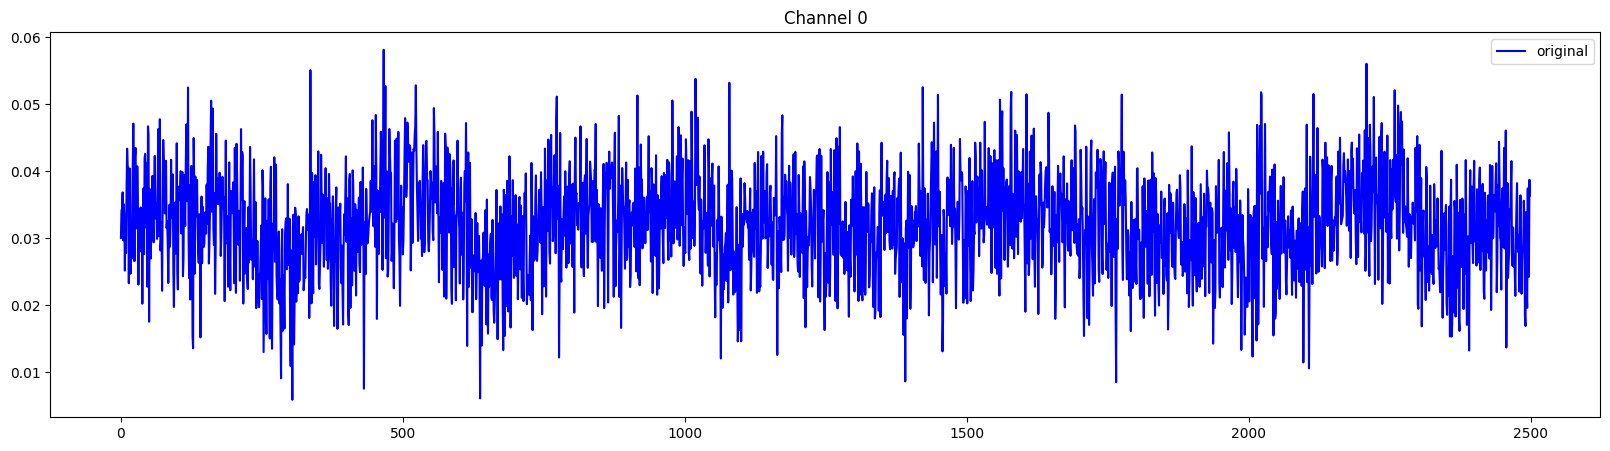

In [12]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

batch_size = 1
dataloader = DataLoader(tuh_eval_data, batch_size=batch_size, shuffle=False)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.to(device)

mask_ratio = 0.4
patch_length = 250
patch_stride = 250

# num patches 
num_patches = context_length//patch_length


def reconstruction_vis(model, dataloader, mask_ratio, sample):
    model.to(device)
    model.eval()

    # get sample th batch from dataloader without looping
    for i, batch in enumerate(dataloader):
        if i == sample:
            seq_x = batch['past_values'].to(device)   # [batch_size, context_length, num_channels]
            print('seq_x.shape', seq_x.shape)
            with torch.no_grad():
                outputs = model(seq_x)
                print(outputs.keys())
                reconstruction = outputs['prediction_output'] # [batch_size, num_channels, num_patches, patch_length]
                reconstruction = reconstruction.permute(0, 2, 3, 1) # [batch_size, num_patches, patch_length, num_channels]
                # reshape to [batch_size, num_patches * patch_length, num_channels]
                reconstruction = reconstruction.reshape(reconstruction.shape[0], -1, reconstruction.shape[3])
                print('reconstruction.shape', reconstruction.shape)

                return reconstruction.cpu().numpy(), seq_x.cpu().numpy()
        
    return None, None

import os
checkpoint_path_dir = '/home/gayal/ssl-project/PatchTST/PatchTST_self_supervised/saved_models/test_run_10_recordings_10k/outputs/'
checkpoint = 'checkpoint-10000'

check_path = os.path.join(checkpoint_path_dir, checkpoint)
model = PatchTSTForPretraining.from_pretrained(check_path)

reconstruction, seq_x = reconstruction_vis(model, dataloader, mask_ratio, 5000)
# if reconstruction == None and seq_x==None:
#     import sys
#     sys.exit(0)

assert reconstruction.shape == seq_x.shape, f"Reconstruction shape {reconstruction.shape} does not match input shape {seq_x.shape}"

# select one channel for visualization
channel = 0
reconstruction = reconstruction[:, :, channel] # [batch_size, num_patches, patch_length]
seq_x = seq_x[:, :, channel] # [batch_size, context_length]

import numpy as np
import matplotlib.pyplot as plt

def plot_reconstruction(reconstruction, seq_x, channel):
    # plot the reconstruction and the original signal
    plt.figure(figsize=(20, 5))
    plt.plot(seq_x[0, :], label='original', color='blue')
    # plt.plot(reconstruction[0, :], label='reconstruction', color='red')
    plt.title(f'Channel {channel}')
    plt.legend()
    plt.show()
# plot the reconstruction and the original signal
reconstruction = reconstruction.reshape(reconstruction.shape[0], -1)
plot_reconstruction(reconstruction, seq_x, channel)

# # save the reconstruction and the original signal
# reconstruction = reconstruction.cpu().numpy()
# seq_x = seq_x.cpu().numpy()
# np.save('reconstruction.npy', reconstruction)
# np.save('seq_x.npy', seq_x)


In [11]:
data_procd_path = '/mnt/ssd_4tb_0/data/tuh_preprocessed_npy_test'
pkl_filename = 'tuh_patient_splits.pkl'

import pandas as pd
import pickle
import os
import numpy as np

def load_patient_splits(data_procd_path, pkl_filename):
    # Load the patient splits from the pickle file
    with open(os.path.join(data_procd_path, pkl_filename), 'rb') as f:
        patient_splits = pickle.load(f)

    return patient_splits

patient_splits = load_patient_splits(data_procd_path, pkl_filename)
patient_splits['val']

['aaaaaqpg']

In [9]:
# find the matching patient_splits['val'][0] in the directory
import os

recording_name = ''

for root, dirs, files in os.walk(data_procd_path):
    for file in files:
        if patient_splits['val'][0] in file:
            recording_name = file
            print(os.path.join(root, file))
            break

recording_name = recording_name.split('_preprocessed.npy')[0]
# find that from the original recording
raw_data_path = '/mnt/hdd_16tb_0/tuh/edf'

edf_file_path = ''
# walk and find the file
for root, dirs, files in os.walk(raw_data_path):
    for file in files:
        if recording_name in file:
            edf_file_path = os.path.join(root, file)
            print(edf_file_path)
            break


/mnt/ssd_4tb_0/data/tuh_preprocessed_npy_test/aaaaaqpg_s001_t000_preprocessed.npy
/mnt/hdd_16tb_0/tuh/edf/112/aaaaaqpg/s001_2014_01_21/01_tcp_ar/aaaaaqpg_s001_t000.edf


Extracting EDF parameters from /mnt/hdd_16tb_0/tuh/edf/112/aaaaaqpg/s001_2014_01_21/01_tcp_ar/aaaaaqpg_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 388999  =      0.000 ...  1555.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


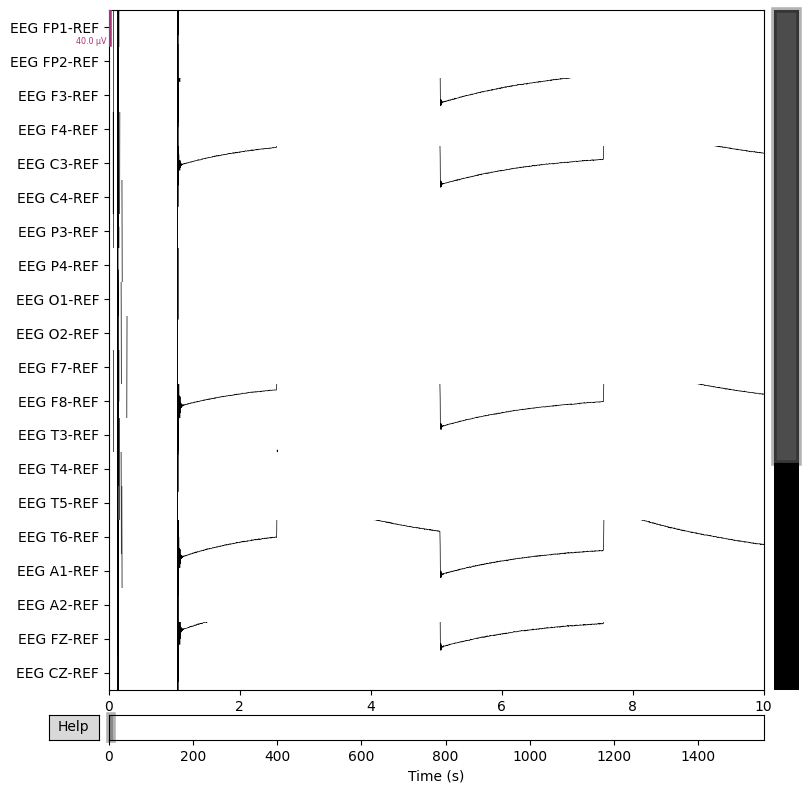

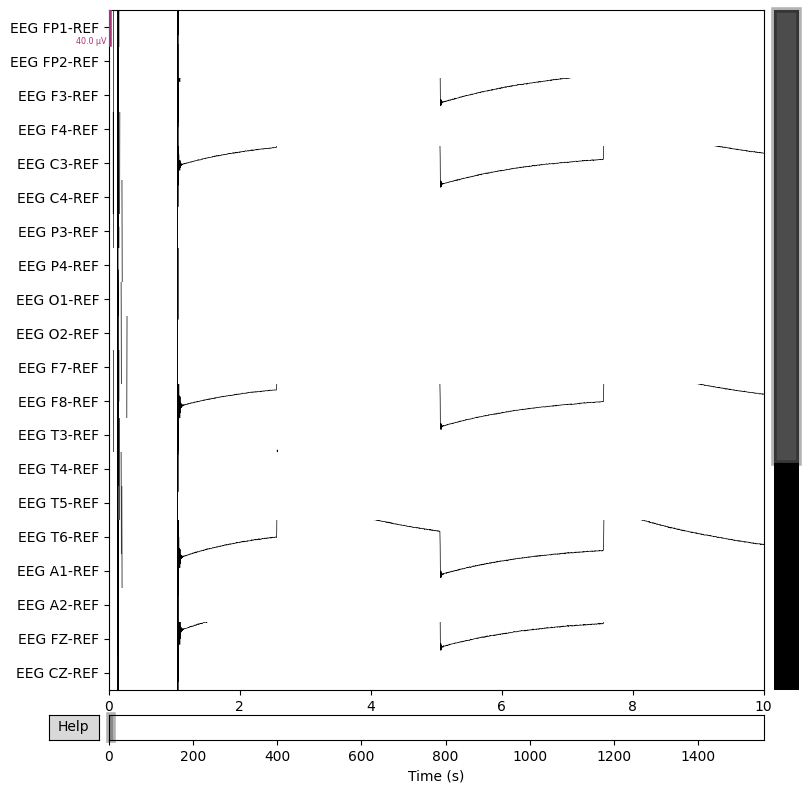

In [17]:
# %matplotlib notebook

import mne
raw = mne.io.read_raw_edf(edf_file_path, preload=True)
raw.load_data()
raw.pick_types(eeg=True)
raw.plot()